In [1]:
import os
import numpy as np
import argparse
import time
import librosa

In [2]:
from utils import *
from model import CycleGAN

In [3]:
import librosa.display
from IPython.display import Audio
import matplotlib.pyplot as plt

In [4]:
%pylab inline
rcParams['figure.figsize'] = (16, 4)

Populating the interactive namespace from numpy and matplotlib


/home/jg/.conda/envs/tf18_p35/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [5]:
# train_A_dir = '/media/jg/H/data/VCC2016/vcc2016_training/SF1'
# train_B_dir = '/media/jg/H/data/VCC2016/vcc2016_training/TM2'
# validation_A_dir = '/media/jg/H/data/VCC2016/evaluation_all/SF1'
# validation_B_dir = '/media/jg/H/data/VCC2016/evaluation_all/TM2'

train_A_dir = './../../../Database/Emotion/hap_neu/hap'
train_B_dir = './../../../Database/Emotion/hap_neu/neu'
validation_A_dir = './../../../Database/Emotion/hap_neu/val_hap'
validation_B_dir = './../../../Database/Emotion/hap_neu/val_neu'
model_name = 'hap2neu.ckpt'
model_dir = './model/hap2neu'
output_dir = './validation_output'

In [6]:
random_seed = 0
np.random.seed(random_seed)

In [7]:
# set training parameters
num_epochs = 5000
mini_batch_size = 1 # mini_batch_size = 1 is better
generator_learning_rate = 0.0002
generator_learning_rate_decay = generator_learning_rate / 200000
discriminator_learning_rate = 0.0001
discriminator_learning_rate_decay = discriminator_learning_rate / 200000
sampling_rate = 16000
num_mcep = 24
frame_period = 5.0
n_frames = 128
lambda_cycle = 10
lambda_identity = 5

In [8]:
# load audio waveform
wavs_A = load_wavs(wav_dir = train_A_dir, sr = sampling_rate)
wavs_B = load_wavs(wav_dir = train_B_dir, sr = sampling_rate)

### TEST Input

(55039,)


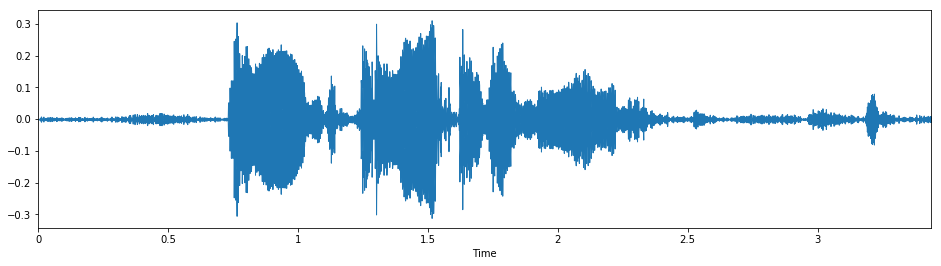

In [9]:
x = wavs_A[1]
print(np.shape(x))
librosa.display.waveplot(x, sr=sampling_rate)
Audio(x, rate=sampling_rate)

In [10]:
# extract Pitch contour (f0s), Harmonic spectral envelope (sps) and Aperiodic spectral envelope (aps)
f0s_A, timeaxes_A, sps_A, aps_A, coded_sps_A = world_encode_data(wavs = wavs_A, fs = sampling_rate, frame_period = frame_period, coded_dim = num_mcep)
f0s_B, timeaxes_B, sps_B, aps_B, coded_sps_B = world_encode_data(wavs = wavs_B, fs = sampling_rate, frame_period = frame_period, coded_dim = num_mcep)


In [11]:
# prepare for log Gaussian Normalized Transform 
log_f0s_mean_A, log_f0s_std_A = logf0_statistics(f0s_A)
log_f0s_mean_B, log_f0s_std_B = logf0_statistics(f0s_B)
print('log f0 of Pitch A: Mean %f, Std %f' %(log_f0s_mean_A, log_f0s_std_A))
print('log f0 of Pitch B: Mean %f, Std %f' %(log_f0s_mean_B, log_f0s_std_B))

log f0 of Pitch A: Mean 5.355179, Std 0.363481
log f0 of Pitch B: Mean 5.242276, Std 0.283226


In [12]:
coded_sps_A_transposed = transpose_in_list(lst = coded_sps_A)
coded_sps_B_transposed = transpose_in_list(lst = coded_sps_B)
coded_sps_A_norm, coded_sps_A_mean, coded_sps_A_std = coded_sps_normalization_fit_transoform(coded_sps = coded_sps_A_transposed)
coded_sps_B_norm, coded_sps_B_mean, coded_sps_B_std = coded_sps_normalization_fit_transoform(coded_sps = coded_sps_B_transposed)
print("Input data fixed.")

Input data fixed.


### F0

(45760,)


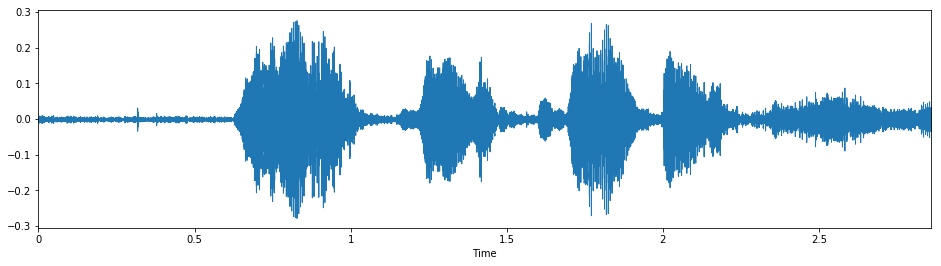

In [13]:
idx = 0
x = wavs_A[idx]
print(np.shape(x))
librosa.display.waveplot(x, sr=sampling_rate)
Audio(x, rate=sampling_rate)

Text(0, 0.5, 'Frequency')

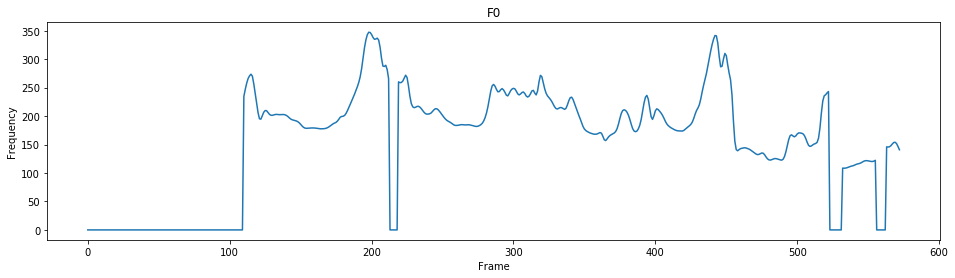

In [14]:
plt.plot(f0s_A[0])
title('F0')
plt.xlabel('Frame')
plt.ylabel('Frequency')

### CHECK preprocessing

In [15]:
print(len(coded_sps_A_norm), np.shape(coded_sps_A_norm[0]))
print(len(coded_sps_B_norm), np.shape(coded_sps_B_norm[0]))
pool_A, pool_B, f0sA, f0sB  = list(coded_sps_A_norm), list(coded_sps_B_norm), list(f0s_A), list(f0s_B)

100 (24, 573)
128 (24, 390)


In [16]:
# Sample proportional to the length
def sample_train_data2(pool_A, pool_B, f0s_A, f0s_B, n_frames=128, max_samples=1000):

#     np.random.shuffle(pool_A)
#     np.random.shuffle(pool_B)
    
    train_data_A = []
    train_data_B = []
    
    while pool_A and pool_B:
        
        idx_A = np.random.randint(len(pool_A))
        idx_B = np.random.randint(len(pool_B))
        data_A, data_B = pool_A[idx_A], pool_B[idx_B]
        data_A_len, data_B_len = data_A.shape[1], data_B.shape[1]   
        f0_A, f0_B = f0s_A[idx_A], f0s_B[idx_B]
        
        if data_A_len < n_frames:
            del pool_A[idx_A]
            del f0s_A[idx_A]
            continue
        
        if data_B_len < n_frames:
            del pool_B[idx_B]
            del f0s_B[idx_B]
            continue
            
        start_A = np.random.randint(data_A_len - n_frames + 1)
        end_A = start_A + n_frames
        if max(f0_A[start_A:end_A]) > 0:
            train_data_A.append(data_A[:,start_A:end_A])
        if start_A >= n_frames and max(f0_A[0:start_A]) > 0:
            pool_A.append(data_A[:,0:start_A])
            f0s_A.append(f0_A[0:start_A])
        if data_A_len - end_A >= n_frames and max(f0_A[end_A:]) > 0:
            pool_A.append(data_A[:,end_A:])
            f0s_A.append(f0_A[end_A:])
        del pool_A[idx_A]
        del f0s_A[idx_A]
 
        start_B = np.random.randint(data_B_len - n_frames + 1)
        end_B = start_B + n_frames
        if max(f0_B[start_B:end_B]) > 0:
            train_data_B.append(data_B[:,start_B:end_B])
        if start_B >= n_frames and max(f0_B[0:start_B]) > 0:
            pool_B.append(data_B[:,0:start_B])
            f0s_B.append(f0_B[0:start_B])
        if data_B_len - end_B >= n_frames and max(f0_B[end_B:]) > 0:
            pool_B.append(data_B[:,end_B:])
            f0s_B.append(f0_B[end_B:])
        del pool_B[idx_B]
        del f0s_B[idx_B]

        # reach maximum data length
        if len(train_data_A) >= max_samples:
            break
    
    num = min(len(train_data_A), len(train_data_B))
    np.random.shuffle(train_data_A)
    np.random.shuffle(train_data_B)
    train_data_A = np.array(train_data_A[0:num])
    train_data_B = np.array(train_data_B[0:num])

    return train_data_A, train_data_B

In [17]:
# dataset_A, dataset_B = sample_train_data(pool_A=pool_A, pool_B=pool_B, n_frames=n_frames, max_samples=1000)
dataset_A, dataset_B = sample_train_data2(pool_A=pool_A, pool_B=pool_B, f0s_A=f0sA, f0s_B=f0sB, n_frames=n_frames, max_samples=1000)
print(np.shape(dataset_A), np.shape(dataset_B))

(416, 24, 128) (416, 24, 128)


In [18]:
# a, b = [1], [1]
# c, d = list(a), list(b)
# c.append(8)
# print(a, b, c, d)

## START Training

In [19]:
n_samples = dataset_A.shape[0]
print(n_samples)

416


In [20]:
# load CycleGAN model (Generator, Discriminator and Loss functions)
model = CycleGAN(num_features = num_mcep)

In [21]:
# Train for 1 epoch
epoch = 0

In [22]:
for i in range(n_samples // mini_batch_size):

    num_iterations = n_samples // mini_batch_size * epoch + i

    if num_iterations > 10000:
        lambda_identity = 0
    if num_iterations > 200000:
        generator_learning_rate = max(0, generator_learning_rate - generator_learning_rate_decay)
        discriminator_learning_rate = max(0, discriminator_learning_rate - discriminator_learning_rate_decay)

    start = i * mini_batch_size
    end = (i + 1) * mini_batch_size

    generator_loss, discriminator_loss = model.train(input_A = dataset_A[start:end], input_B = dataset_B[start:end], lambda_cycle = lambda_cycle, lambda_identity = lambda_identity, generator_learning_rate = generator_learning_rate, discriminator_learning_rate = discriminator_learning_rate)

    if i % 50 == 0:
        #print('Iteration: %d, Generator Loss : %f, Discriminator Loss : %f' % (num_iterations, generator_loss, discriminator_loss))
        print('Iteration: {:07d}, Generator Learning Rate: {:.7f}, Discriminator Learning Rate: {:.7f}, Generator Loss : {:.3f}, Discriminator Loss : {:.3f}'.format(num_iterations, generator_learning_rate, discriminator_learning_rate, generator_loss, discriminator_loss))


Iteration: 0000000, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 28.944, Discriminator Loss : 0.566
Iteration: 0000050, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 24.630, Discriminator Loss : 0.539
Iteration: 0000100, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 29.004, Discriminator Loss : 0.153
Iteration: 0000150, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 25.537, Discriminator Loss : 0.042
Iteration: 0000200, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 24.316, Discriminator Loss : 0.008
Iteration: 0000250, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 25.537, Discriminator Loss : 0.035
Iteration: 0000300, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss :

In [23]:
model.save(directory = model_dir, filename = model_name)

'./model/hap2neu/hap2neu.ckpt'

### SET output dir

In [24]:
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
np.savez(os.path.join(model_dir, 'logf0s_normalization.npz'), mean_A = log_f0s_mean_A, std_A = log_f0s_std_A, mean_B = log_f0s_mean_B, std_B = log_f0s_std_B)
np.savez(os.path.join(model_dir, 'mcep_normalization.npz'), mean_A = coded_sps_A_mean, std_A = coded_sps_A_std, mean_B = coded_sps_B_mean, std_B = coded_sps_B_std)

if validation_A_dir is not None:
    validation_A_output_dir = os.path.join(output_dir, 'converted_A')
    if not os.path.exists(validation_A_output_dir):
        os.makedirs(validation_A_output_dir)

if validation_B_dir is not None:
    validation_B_output_dir = os.path.join(output_dir, 'converted_B')
    if not os.path.exists(validation_B_output_dir):
        os.makedirs(validation_B_output_dir)

## Evaluation

In [25]:
if validation_A_dir is not None:
    if epoch % 50 == 0:
        print('Generating Validation Data B from A...')
        for file in os.listdir(validation_A_dir):
            filepath = os.path.join(validation_A_dir, file)
            wav, _ = librosa.load(filepath, sr = sampling_rate, mono = True)
            wav = wav_padding(wav = wav, sr = sampling_rate, frame_period = frame_period, multiple = 4)
            f0, timeaxis, sp, ap = world_decompose(wav = wav, fs = sampling_rate, frame_period = frame_period)
            f0_converted = pitch_conversion(f0 = f0, mean_log_src = log_f0s_mean_A, std_log_src = log_f0s_std_A, mean_log_target = log_f0s_mean_B, std_log_target = log_f0s_std_B)
            coded_sp = world_encode_spectral_envelop(sp = sp, fs = sampling_rate, dim = num_mcep)
            coded_sp_transposed = coded_sp.T
            coded_sp_norm = (coded_sp_transposed - coded_sps_A_mean) / coded_sps_A_std
            coded_sp_converted_norm = model.test(inputs = np.array([coded_sp_norm]), direction = 'A2B')[0]
            coded_sp_converted = coded_sp_converted_norm * coded_sps_B_std + coded_sps_B_mean
            coded_sp_converted = coded_sp_converted.T
            coded_sp_converted = np.ascontiguousarray(coded_sp_converted)
            decoded_sp_converted = world_decode_spectral_envelop(coded_sp = coded_sp_converted, fs = sampling_rate)
            wav_transformed = world_speech_synthesis(f0 = f0_converted, decoded_sp = decoded_sp_converted, ap = ap, fs = sampling_rate, frame_period = frame_period)
#             librosa.output.write_wav(os.path.join(validation_A_output_dir, os.path.basename(file)), wav_transformed, sampling_rate)
            break

Generating Validation Data B from A...


/media/jg/D/Dropbox/JianTembine/Coding/TensorFlow/EmoCycleGAN/utils.py:183: RuntimeWarning: divide by zero encountered in log
  f0_converted = np.exp((np.log(f0) - mean_log_src) / std_log_src * std_log_target + mean_log_target)


### TEST Output

(116720,)


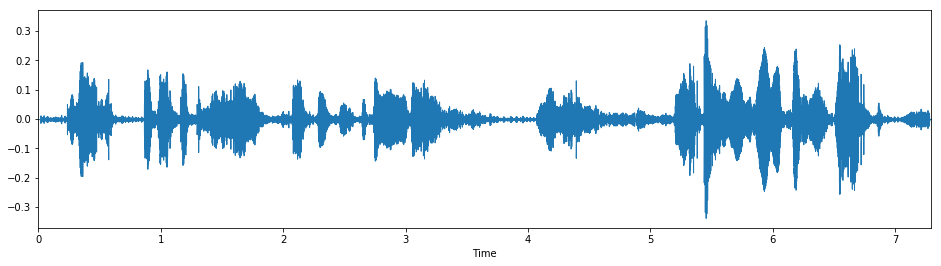

In [26]:
A = wav
print(np.shape(A))
librosa.display.waveplot(A, sr=sampling_rate)
Audio(A, rate=sampling_rate)

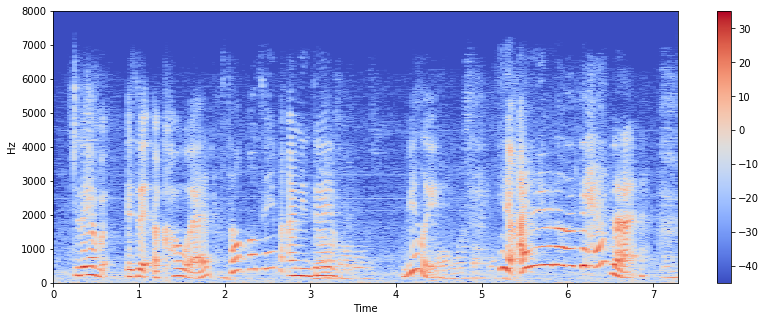

In [27]:
X = librosa.stft(A)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sampling_rate, x_axis='time', y_axis='hz')
colorbar()

(116800,)


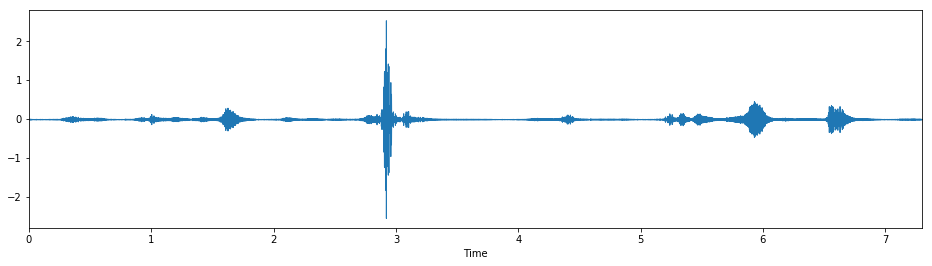

In [28]:
A2B = wav_transformed
print(np.shape(A2B))
librosa.display.waveplot(A2B, sr=sampling_rate)
Audio(A2B, rate=sampling_rate)

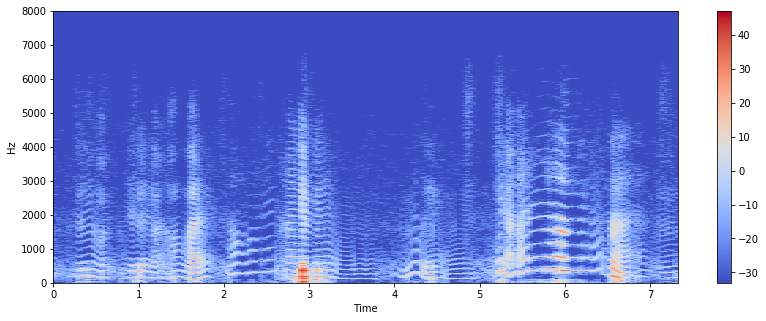

In [29]:
X = librosa.stft(A2B)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sampling_rate, x_axis='time', y_axis='hz')
colorbar()

In [30]:
if validation_B_dir is not None:
    if epoch % 50 == 0:
        print('Generating Validation Data A from B...')
        for file in os.listdir(validation_B_dir):
            filepath = os.path.join(validation_B_dir, file)
            wav, _ = librosa.load(filepath, sr = sampling_rate, mono = True)
            wav = wav_padding(wav = wav, sr = sampling_rate, frame_period = frame_period, multiple = 4)
            f0, timeaxis, sp, ap = world_decompose(wav = wav, fs = sampling_rate, frame_period = frame_period)
            f0_converted = pitch_conversion(f0 = f0, mean_log_src = log_f0s_mean_B, std_log_src = log_f0s_std_B, mean_log_target = log_f0s_mean_A, std_log_target = log_f0s_std_A)
            coded_sp = world_encode_spectral_envelop(sp = sp, fs = sampling_rate, dim = num_mcep)
            coded_sp_transposed = coded_sp.T
            coded_sp_norm = (coded_sp_transposed - coded_sps_B_mean) / coded_sps_B_std
            coded_sp_converted_norm = model.test(inputs = np.array([coded_sp_norm]), direction = 'B2A')[0]
            coded_sp_converted = coded_sp_converted_norm * coded_sps_A_std + coded_sps_A_mean
            coded_sp_converted = coded_sp_converted.T
            coded_sp_converted = np.ascontiguousarray(coded_sp_converted)
            decoded_sp_converted = world_decode_spectral_envelop(coded_sp = coded_sp_converted, fs = sampling_rate)
            wav_transformed = world_speech_synthesis(f0 = f0_converted, decoded_sp = decoded_sp_converted, ap = ap, fs = sampling_rate, frame_period = frame_period)
#             librosa.output.write_wav(os.path.join(validation_B_output_dir, os.path.basename(file)), wav_transformed, sampling_rate)
            break

Generating Validation Data A from B...


/media/jg/D/Dropbox/JianTembine/Coding/TensorFlow/EmoCycleGAN/utils.py:183: RuntimeWarning: divide by zero encountered in log
  f0_converted = np.exp((np.log(f0) - mean_log_src) / std_log_src * std_log_target + mean_log_target)


(67440,)


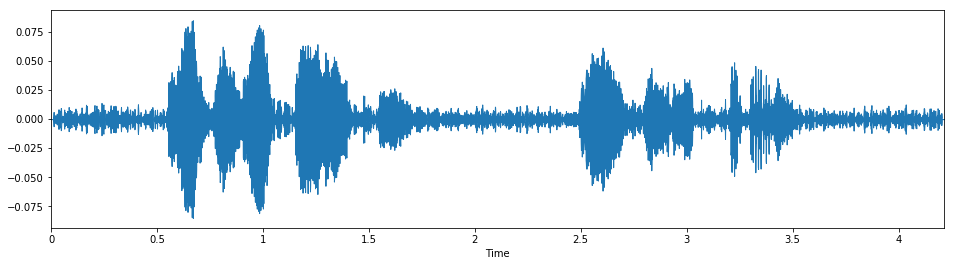

In [31]:
B = wav
print(np.shape(B))
librosa.display.waveplot(B, sr=sampling_rate)
Audio(B, rate=sampling_rate)

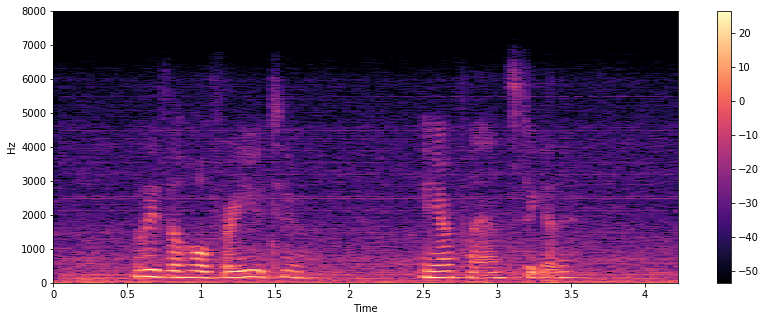

In [32]:
X = librosa.stft(B)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sampling_rate, x_axis='time', y_axis='hz')
colorbar()

(67520,)


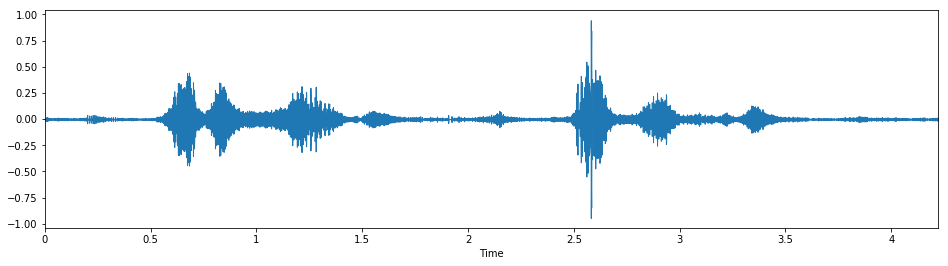

In [33]:
B2A = wav_transformed
print(np.shape(B2A))
librosa.display.waveplot(B2A, sr=sampling_rate)
Audio(B2A, rate=sampling_rate)

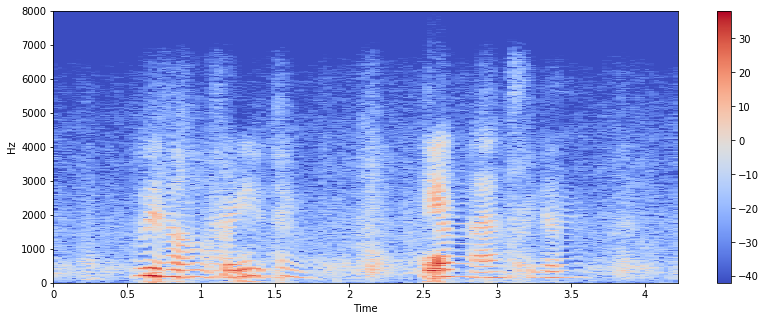

In [34]:
X = librosa.stft(B2A)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sampling_rate, x_axis='time', y_axis='hz')
colorbar()

## Test wav padding

In [35]:
# # def wav_padding(wav, sr, frame_period, multiple = 4):
# # multiple=4 blocks, each block is 5ms with 0.005*16000=80 frames. 
# # minimum 4 bloacks, 4, 8, 12, ... 
# # after padding, frames: 560, 880, 1200, ...
# num_frames = 280
# sr = 16000
# multiple = 4
# num_frames_padded = int((np.ceil((np.floor(num_frames / (sr * frame_period / 1000)) + 1) / multiple + 1) * multiple - 1) * (sr * frame_period / 1000))
# num_frames_diff = num_frames_padded - num_frames
# num_pad_left = num_frames_diff // 2
# num_pad_right = num_frames_diff - num_pad_left
# print(num_pad_left, num_pad_left)
# print(num_frames_padded)